In [1]:
#!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
print(train_data.shape)
print(test_data.shape)

(191, 13)
(48, 13)


# Preprocessing

## Drop delle colonne ritenute superflue, separazione train/test in X, y

In [5]:
X_train = train_data.drop(columns=['DEATH_EVENT', 'time'])
y_train = train_data['DEATH_EVENT']

X_test = test_data.drop(columns=['DEATH_EVENT', 'time'])
y_test = test_data['DEATH_EVENT']

### Feature che considera tutti i fattori di rischio (booleani) insieme

In [6]:
boolean_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'smoking']

In [7]:
X_train[boolean_features].sum(axis=1)
X_train['risk_factor'] = X_train[boolean_features].sum(axis=1)
#X_train = X_train.drop(columns=boolean_features)

X_test[boolean_features].sum(axis=1)
X_test['risk_factor'] = X_test[boolean_features].sum(axis=1)
#X_test = X_test.drop(columns=boolean_features)

In [8]:
X_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,risk_factor
0,60.0,1,2281,1,40,0,283000.00,1.0,141,0,0,2
1,57.0,1,129,0,30,0,395000.00,1.0,140,0,0,1
2,53.0,1,582,0,45,0,305000.00,1.1,137,1,1,2
3,51.0,1,582,1,35,0,263358.03,1.5,136,1,1,3
4,64.0,1,62,0,60,0,309000.00,1.5,135,0,0,1


# Scelta dei modelli, training e fit

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

## DecisionTree

In [10]:
max_loop_depth = 7
max_score = 0
best_depth = 0

for depth in range(1, max_loop_depth):
    model = DecisionTreeClassifier(max_depth=depth, random_state=1)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    if(score > max_score):
        max_score = score
        best_depth = depth
    
best_model = DecisionTreeClassifier(max_depth=best_depth)
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [ ]:
if(type(best_model).__name__ in ('DecisionTreeClassifier', 'RandomForestClassifier')):
    sns.set_style("whitegrid")

    fig, axes = plt.subplots(nrows = 1, ncols = 1, sharex="all", figsize=(8,6))

    indices = np.argsort(best_model.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40],x = best_model.feature_importances_[indices][:40] , orient='h')
    g.set_xlabel("Relative importance",fontsize=12)
    g.set_ylabel("Features",fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(type(best_model).__name__ + " feature importance")

In [11]:
print('Training Accuracy: ', best_model.score(X_train, y_train) * 100, '%')
print('Testing Accuracy: ', best_model.score(X_test, y_test) * 100, '%')

Training Accuracy:  84.81675392670157 %
Testing Accuracy:  83.33333333333334 %


## Confusion Matrix

I valori sulle righe sono i true value, le colonne della matrice quelli predetti

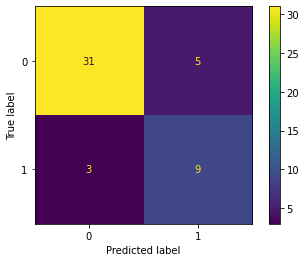

In [12]:
plot_confusion_matrix(best_model, X_test, y_test) #normalize='true'
plt.grid(False)
plt.show()

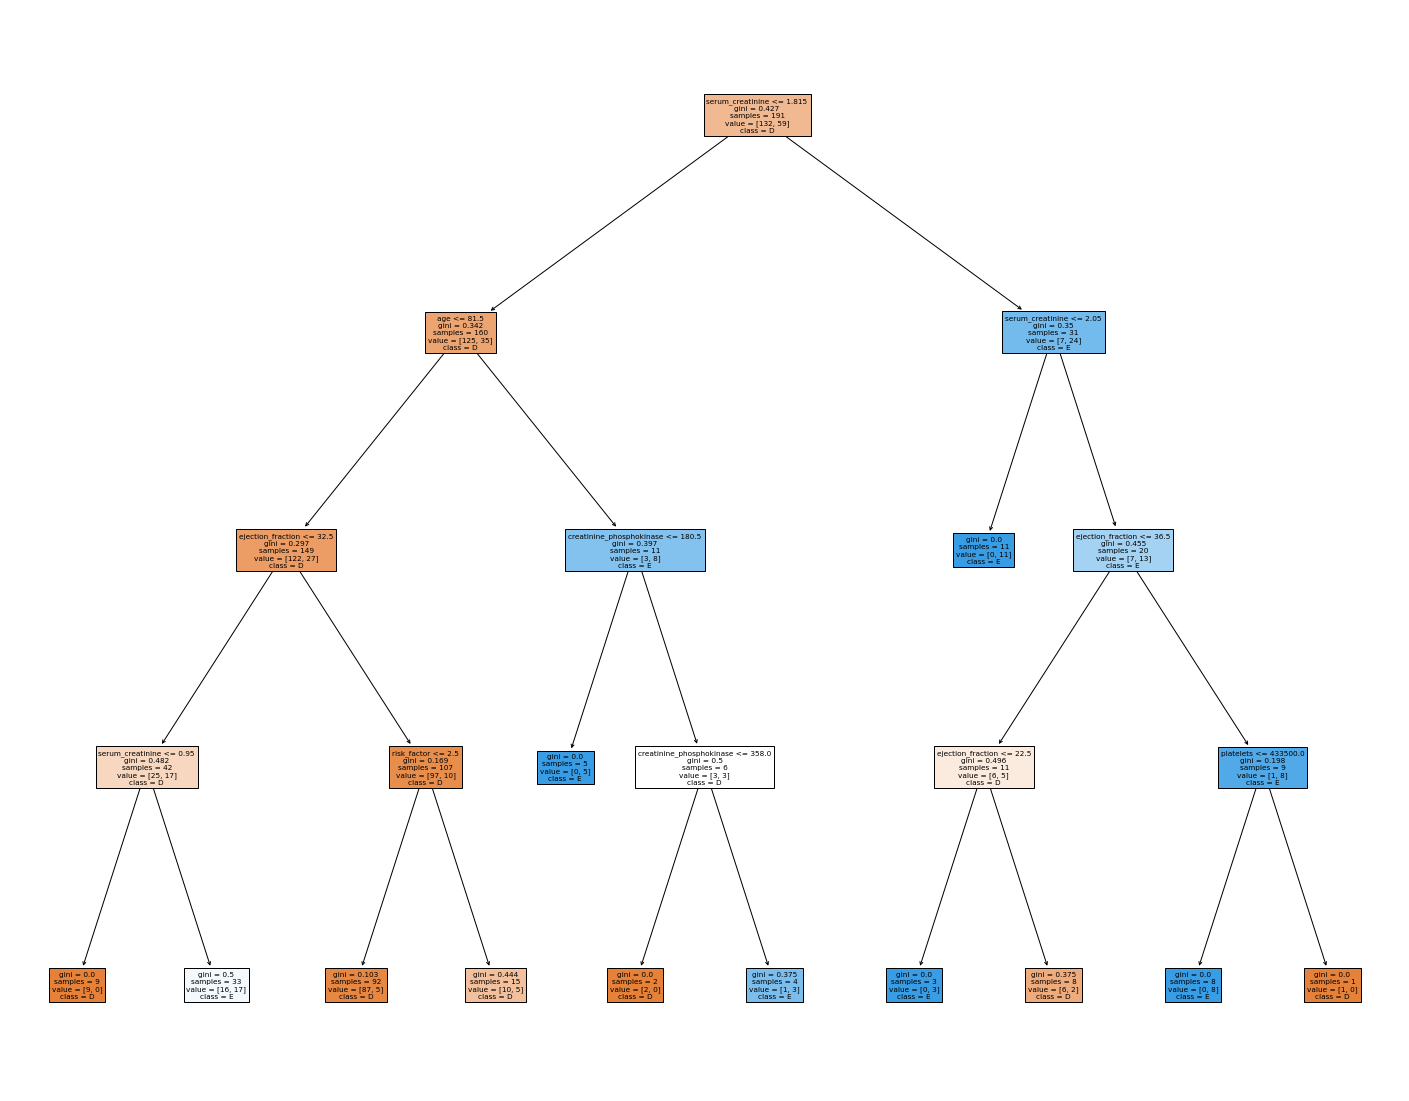

In [13]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(best_model, 
                   feature_names=X_train.columns,  
                   class_names=y_train.name,
                   filled=True)

### GridSearchCV e Pipeline

La GridSearchCV è utile per stimare il modello coi migliori parametri, per ogni combinazione dei modelli e parametri forniti. Viene anche effettuata la Cross Validation (CV) per rendere più affidabile lo score calcolato (valori di k-fold ottimali sono k=5 e k=10). 

La Leave-One-Out con k=n_osservazioni non viene consigliata nella pratica, e non è neanche possibile utilizzarla nella GridSearchCV poiché essa usa una StratifiedKFold, che mantiene le proporzioni delle classi di target nel validation set, necessitando che ci sia almeno un rappresentante per ogni valore possibile.

Si effettua quindi una ricerca nello spazio dei parametri dei classificatori indicati, facendo fit su tutte le possibili combinazioni specificate tramite la lista dizionari params. Infine sceglie il miglior modello e suoi migliori parametri da una tabella che calcola man mano (gridsearch.cv_results_) dove ci sono i ranking di tutte le possibili scelte effettuate.

GridSearchCV prende come parametri la Pipeline (su cui fare fit_transform/transform a seconda dei dati di train/test) e il numero di k-fold da effettuare nella Cross Validation.

In [14]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([
        ('inputer', SimpleImputer(strategy='median')),
        ('model', DecisionTreeClassifier())
        ])

In [15]:
params = [
            #{'model': [DecisionTreeClassifier()],
            #'model__max_depth': np.arange(4,6)},
            {'model': [LogisticRegression()],
            'model__max_iter': [1000],
            'model__penalty': ['l2', 'l1'], #[['l1', 'l2']]
            'model__C': np.logspace(-5, 5, 50)},
            {'model': [RandomForestClassifier()],
            'model__n_estimators': [10, 100],
            'model__max_features': ['auto', 'sqrt'],
            'model__min_samples_leaf': [1, 2, 4],
            'model__min_samples_split': [2, 5, 10],
            'model__max_depth': np.arange(1,8)},
            #{'model': [KNeighborsClassifier()],
            #'model__n_neighbors': np.arange(2,6),
            #'model__leaf_size': list(range(10,30)),
            #'model__p': [1, 2]}
            ]

In [16]:
from sklearn.model_selection import GridSearchCV
gridsearch = GridSearchCV(pipe, params, cv=10, verbose=1, n_jobs=4).fit(X_train, y_train) #cv=5 o 10
#print('Score migliore di test accuracy: ', gridsearch.score(X_test, y_test))

Fitting 10 folds for each of 478 candidates, totalling 4780 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 1113 tasks      | elapsed:   41.8s
[Parallel(n_jobs=4)]: Done 1370 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1720 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 2170 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 2720 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done 3370 tasks      | elapsed:  9.3min
[Parallel(n_jobs=4)]: Done 4120 tasks      | elapsed: 12.2min
[Parallel(n_jobs=4)]: Done 4780 out of 4780 | elapsed: 15.1min finished


Di seguito la classifica dei migliori modelli valutati dalla GridSearch, ordinati per media degli score calcolati durante la CV

In [28]:
gs = pd.DataFrame(gridsearch.cv_results_)
ranking = gs[['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score', ascending=True).head(10)
ranking

,params,mean_test_score,rank_test_score
376,"{'model': RandomForestClassifier(max_depth=6, ...",0.796053,1
373,"{'model': RandomForestClassifier(max_depth=6, ...",0.786053,2
457,"{'model': RandomForestClassifier(max_depth=6, ...",0.780789,3
475,"{'model': RandomForestClassifier(max_depth=6, ...",0.780526,4
392,"{'model': RandomForestClassifier(max_depth=6, ...",0.780526,4
397,"{'model': RandomForestClassifier(max_depth=6, ...",0.780263,6
76,"{'model': LogisticRegression(), 'model__C': 56...",0.775789,7
92,"{'model': LogisticRegression(), 'model__C': 24...",0.775789,7
66,"{'model': LogisticRegression(), 'model__C': 54...",0.775789,7
58,"{'model': LogisticRegression(), 'model__C': 8....",0.775789,7


In [29]:
for rank in ranking['params']:
    print(rank)

{'model': RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=10), 'model__max_depth': 6, 'model__max_features': 'auto', 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 10}
{'model': RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=10), 'model__max_depth': 6, 'model__max_features': 'auto', 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 10}
{'model': RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=10), 'model__max_depth': 7, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 10}
{'model': RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=10), 'model__max_depth': 7, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 10}
{'model': RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=10),

Informazioni sui parametri del miglior modello trovato, e sull'importanza delle feature per la classificazione

In [18]:
best_grid_model = gridsearch.best_estimator_['model']

print(best_grid_model)
best_grid_model.get_params()

RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=10)


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

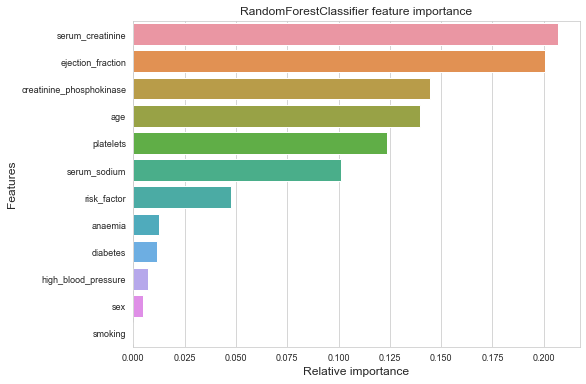

In [19]:
if(type(best_grid_model).__name__ in ('DecisionTreeClassifier', 'RandomForestClassifier')):
    sns.set_style("whitegrid")

    fig, axes = plt.subplots(nrows = 1, ncols = 1, sharex="all", figsize=(8,6))

    indices = np.argsort(best_grid_model.feature_importances_)[::-1][:40]
    g = sns.barplot(y=X_train.columns[indices][:40],x = best_grid_model.feature_importances_[indices][:40] , orient='h')
    g.set_xlabel("Relative importance",fontsize=12)
    g.set_ylabel("Features",fontsize=12)
    g.tick_params(labelsize=9)
    g.set_title(type(best_grid_model).__name__ + " feature importance")

In [20]:
if(type(best_grid_model).__name__ == 'DecisionTreeClassifier' ):
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(best_grid_model, 
                   feature_names=X_train.columns,  
                   class_names=y_train.name,
                   filled=True)

## Confusion Matrix

I valori sulle righe sono i true value, le colonne della matrice quelli predetti

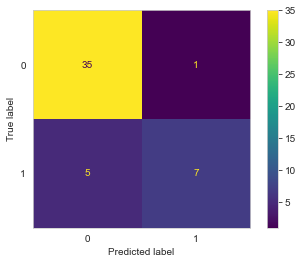

In [21]:
plot_confusion_matrix(gridsearch.best_estimator_[1], X_test, y_test) #normalize='true'
plt.grid(False)
plt.show()

## Risultato di Accuracy del miglior modello scelto

In [22]:
best_grid_model = gridsearch.best_estimator_['model']
print(best_grid_model)
print('Training Accuracy: ', best_grid_model.score(X_train, y_train) * 100, '%')
print('Testing Accuracy: ', best_grid_model.score(X_test, y_test) * 100, '%')

RandomForestClassifier(max_depth=6, min_samples_split=10, n_estimators=10)
Training Accuracy:  91.09947643979058 %
Testing Accuracy:  87.5 %
